# Rolling Planning mit Flow Time

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

from src.utils.production_process import initialize as init
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.lp import flowtime_scheduling as lp_ft_schedule
from src.models.lp import flowtime_rescheduling as lp_ft_reschedule

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Extern
import pandas as pd
pd.set_option('display.min_rows', 16)
pd.set_option('display.max_rows', 21)

In [2]:
max_time = 60*15 # 15 min

In [ ]:
# Datei laden
basic_data_path = get_path("data", "basic")
df_routings = pd.read_csv(basic_data_path / "instance.csv")

## Generierung des Datensatzes für 5 Tage (Ankunft)

In [4]:
day_count = 5

df_jssp, df_jobs_times = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = day_count, shift_length = 1440,
                                                        u_b_mmax = 0.95, shuffle = True
                                                       )
df_jobs_times

,Job,Production_Plan_ID,Arrival
0,0,0,51
1,1,1,136
2,2,2,158
3,3,3,236
4,4,4,404
5,5,5,485
6,6,6,501
7,7,7,528
...,...,...,...
81,81,0,6565


In [5]:
df_jssp

,Job,Production_Plan_ID,Operation,Machine,Processing Time
0,0,0,0,M00,29
1,0,0,1,M01,78
2,0,0,2,M02,9
3,0,0,3,M03,36
4,0,0,4,M04,49
5,0,0,5,M05,11
6,0,0,6,M06,62
7,0,0,7,M07,56
...,...,...,...,...,...
882,88,5,2,M05,52


## Params

In [6]:
# fix
day_length = 1440

In [7]:
# init
day_numb = 0

day_start = 0
day_end = 0
planning_end = 0

# Initialisierung (Tag 0)

In [8]:
day_numb = 0

In [9]:
day_start = day_length*day_numb                      # 0
day_end = day_start + day_length                     # 1440

In [10]:
# I)
df_jssp_curr, df_times_curr = process_filter.jobs_by_arrival_window(df_jobs_times, df_jssp, day_start, day_end)
df_jssp_curr

,Job,Production_Plan_ID,Operation,Machine,Processing Time
0,0,0,0,M00,29
1,0,0,1,M01,78
2,0,0,2,M02,9
3,0,0,3,M03,36
4,0,0,4,M04,49
5,0,0,5,M05,11
6,0,0,6,M06,62
7,0,0,7,M07,56
...,...,...,...,...,...
172,17,3,2,M00,71


In [11]:
df_times_curr 

,Job,Production_Plan_ID,Arrival
0,0,0,51
1,1,1,136
2,2,2,158
3,3,3,236
4,4,4,404
5,5,5,485
6,6,6,501
7,7,7,528
8,8,8,550
9,9,9,559


### Scheduling

In [12]:
df_schedule = lp_ft_schedule.solve_jssp(df_jssp_curr, df_times_curr, solver= "HiGHS", var_cat="Integer", msg=False, timeLimit=max_time, gapRel= 0.02)
df_schedule

BigM: 11000

Solver-Informationen:
  Summe Flow Times        : 11812.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 1728
  Anzahl Constraints      : 3240
  Laufzeit                : ~180.20 Sekunden


,Job,Production_Plan_ID,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,0,0,0,51,M00,51.0,29.0,29.0,80.0
1,0,0,1,51,M01,80.0,78.0,107.0,158.0
2,0,0,2,51,M02,158.0,9.0,116.0,167.0
3,0,0,3,51,M03,167.0,36.0,152.0,203.0
4,0,0,4,51,M04,203.0,49.0,201.0,252.0
5,0,0,5,51,M05,252.0,11.0,212.0,263.0
6,0,0,6,51,M06,263.0,62.0,274.0,325.0
7,0,0,7,51,M07,325.0,56.0,330.0,381.0
...,...,...,...,...,...,...,...,...,...
172,9,9,2,559,M02,697.0,61.0,199.0,758.0


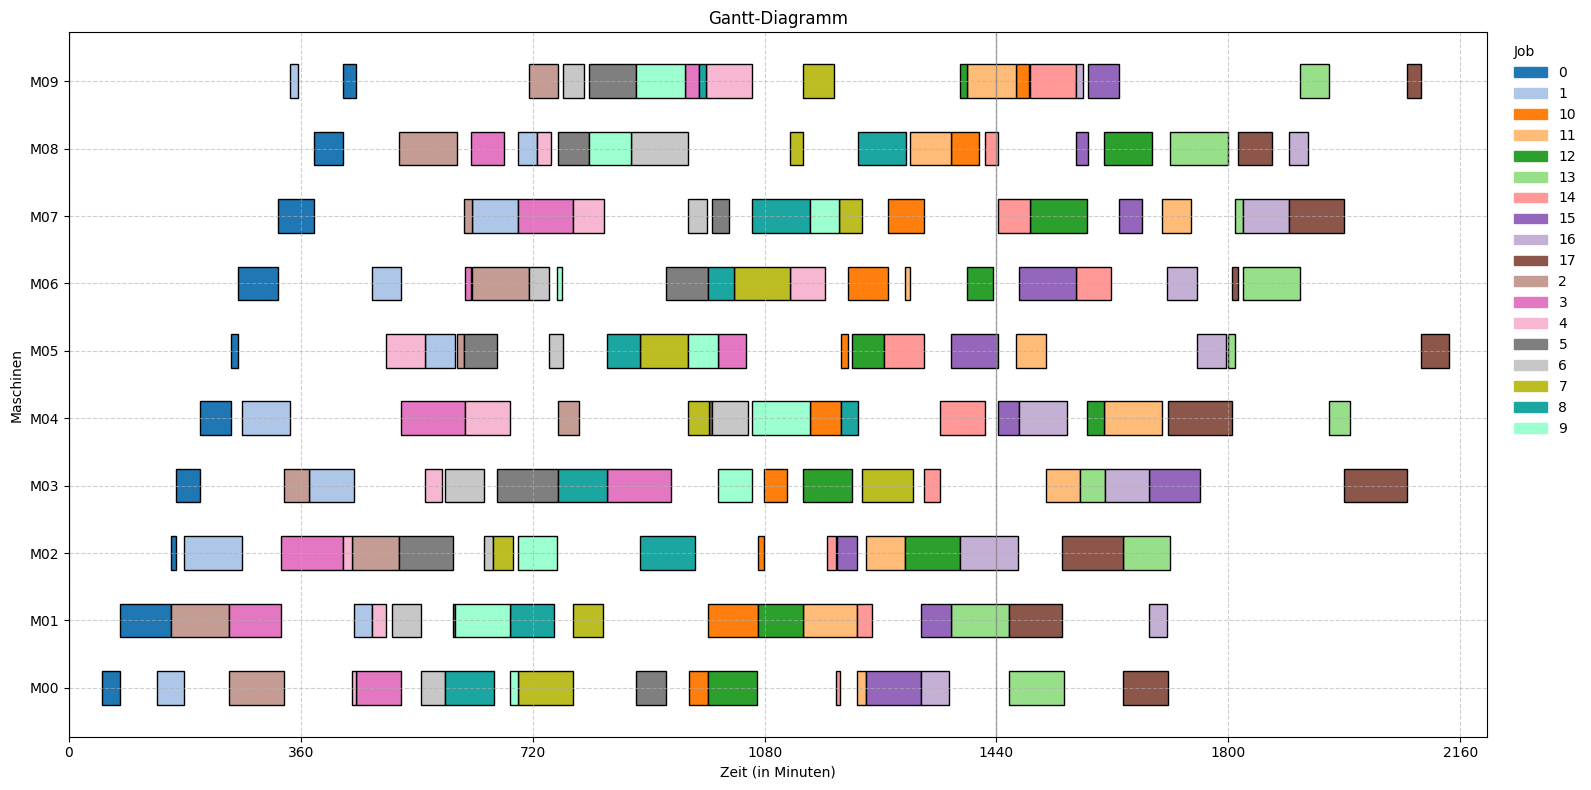

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [13]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

### Simulation

In [14]:
simulation = ProductionSimulation(df_schedule, sigma=0.25)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[00:51:00] Job 0 started on M00
[01:32:22] Job 0 finished on M00 (after 41 minutes 22 seconds)
[01:32:22] Job 0 started on M01
[02:16:00] Job 1 started on M00
[02:49:36] Job 0 finished on M01 (after 77 minutes 14 seconds)
[02:49:36] Job 2 started on M01
[02:49:36] Job 0 started on M02
[02:56:17] Job 1 finished on M00 (after 40 minutes 17 seconds)
[02:59:15] Job 0 finished on M02 (after 09 minutes 39 seconds)
[02:59:15] Job 1 started on M02
[02:59:15] Job 0 started on M03
[03:39:06] Job 0 finished on M03 (after 39 minutes 51 seconds)
[03:39:06] Job 0 started on M04
[04:29:39] Job 2 finished on M01 (after 100 minutes 02 seconds)
[04:29:39] Job 3 started on M01
[04:29:39] Job 2 started on M00
[04:34:15] Job 1 finished on M02 (after 95 minutes)
[04:39:47] Job 0 finished on M04 (after 60 minutes 41 seconds)
[04:39:47] Job 1 started on M04
[04:39:47] Job 0 started on M05
[04:48:55] Job 0 finished on M05 (after 09 minutes 08 seconds)
[04:48:55] Job 0 started on M06
[05:36:40] Job 3 finished o

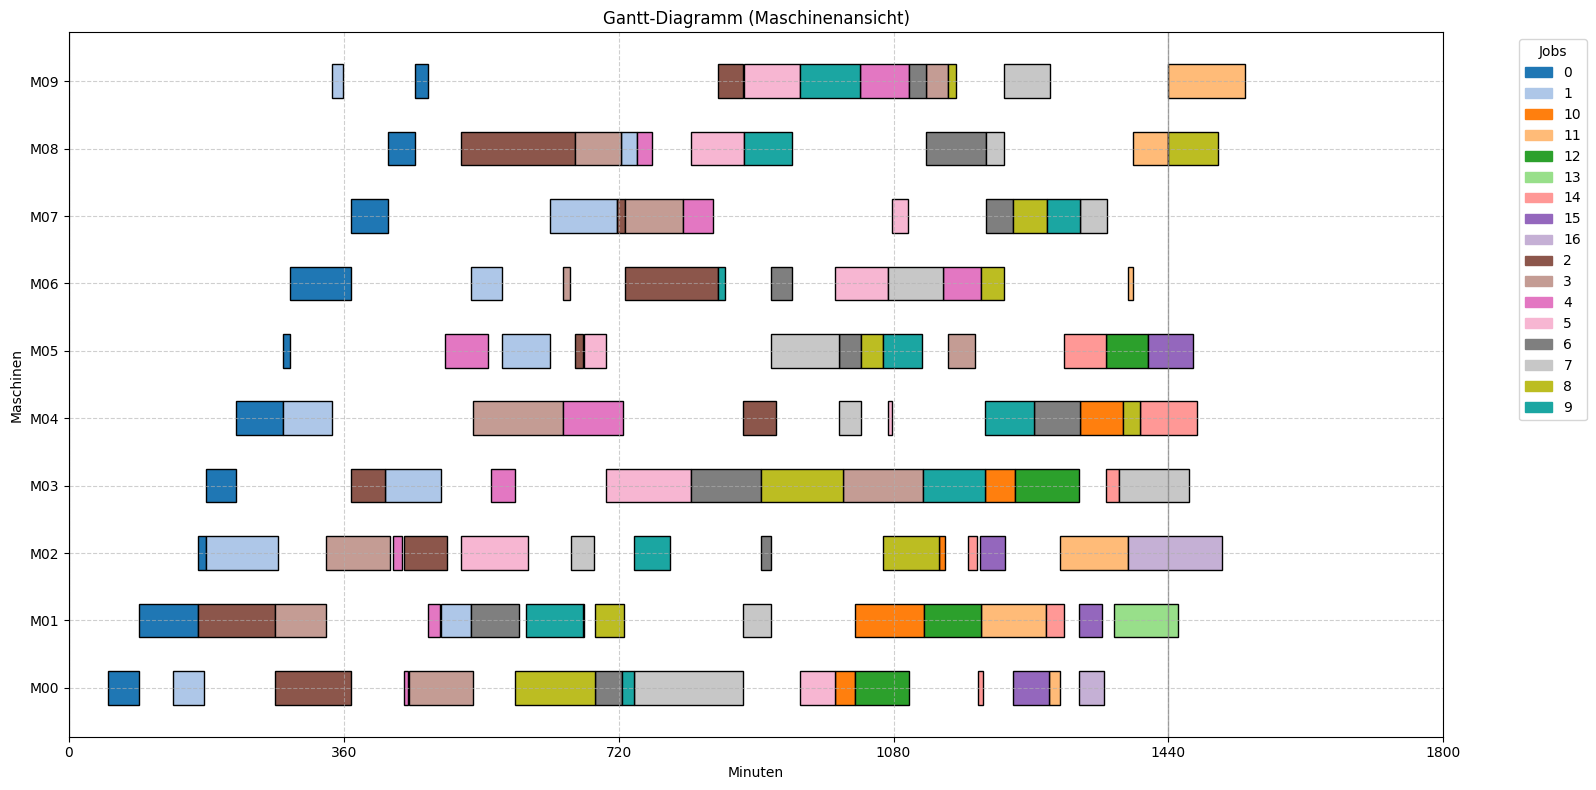

In [15]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution)
else:
    print(f"Nothing executed on day {day_numb}")

In [16]:
df_plan_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
df_plan_undone 

,Job,Production_Plan_ID,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,10,0,5,963,M05,1199.0,11.0,247.0,1210.0
1,10,0,6,963,M06,1210.0,62.0,309.0,1272.0
2,10,0,7,963,M07,1272.0,56.0,365.0,1328.0
3,10,0,8,963,M08,1369.0,44.0,450.0,1413.0
4,10,0,9,963,M09,1470.0,21.0,528.0,1491.0
5,11,9,6,969,M05,1470.0,47.0,548.0,1517.0
6,11,9,7,969,M03,1517.0,52.0,600.0,1569.0
7,11,9,8,969,M04,1607.0,90.0,728.0,1697.0
...,...,...,...,...,...,...,...,...,...
44,17,3,2,1343,M00,1636.0,71.0,364.0,1707.0


#### Export

In [17]:
export_data_path = get_path("data", "lp_flowtime")

In [18]:
df_jssp.to_csv(export_data_path / "02_flowtime_all_jssp.csv", index = False)
df_jobs_times.to_csv(export_data_path / "02_flowtime_all_times.csv", index = False)

In [19]:
df_schedule.to_csv(export_data_path / "02_flowtime_init_schedule.csv", index = False)
df_execution.to_csv(export_data_path / "02_flowtime_execution.csv", index = False)
df_plan_undone.to_csv(export_data_path / "02_flowtime_init_undone.csv", index = False)